# Plotting the J1407 system and our ALMA observations of the region

Here, I want to reproduce Matt's plot of the locations of the targets and emission at the 3 epochs while using the data itself to calculate the proper motions in astropy. 

In [1]:
from astropy.coordinates import SkyCoord, ICRS
from astropy.time import Time
import astropy.units as u
import numpy as np

import paths

from astropy.io import fits
from astropy.wcs import WCS
#from astropy.wcs.utils import remove_redundant_axes
import matplotlib.pyplot as plt

# for statistical analysis
#from casatasks import imfit
#from matplotlib.patches import Ellipse


%matplotlib inline
import warnings; warnings.simplefilter('ignore')
from pprint import pprint #to output the results of imfit in a way I can read


## Calculate the expected proper motion of the objects

Using the first (from the eclipse paper) and second (from ALMA and GAIA) epoch of observations, derive the proper motions of the J1407 system and the ALMA object.  Add those proper motion properties to the SkyCoord objects.

with SkyCoord objects that have their proper motions included, I can use `OBJECT.apply_space_motion()` to get it's position at any future time.

In [2]:
# set the times of the first and second epoch observations
t_1ep = Time('2007-04-30')
t_2ep = Time('2017-07-20')

# skycoord object for initial eclipse observation in 2007 (1st epoch)
c_1ep_gaia_eclipse = SkyCoord(3.69921916846516 * u.rad, 
                              -0.693976463829901 * u.rad,
                           frame='icrs',obstime=t_1ep)

# skycoord object for ALMA detection
c_2ep_ALMA_source = SkyCoord('14h07m47.93110s', '-39d45m43.26068s', 
                             frame='icrs',obstime=t_2ep)
# skycoord object for 2nd epoch on J1407 (from Gaia?)
c_2ep_gaia_J1407 = SkyCoord(3.69921768251056 * u.rad, 
                            -0.693977512133849 * u.rad, 
                            frame='icrs',obstime=t_2ep)


def derive_pm(first,second,t_first,t_second):
    """ 
    * calculate the proper motion of the object from the two epochs of data
    * add those derived proper motion properties to a new SkyCoord object
      for the source
    """
    # find the differences
    dt = (t_second - t_first)
    dra = (second.ra - first.ra)
    ddec = (second.dec - first.dec)
    
    # find the proper motions in both directions
    pm_ra_cosdec, pm_dec = (dra*np.cos(first.dec.rad))/dt, ddec/dt
    
    # create a new SkyCoord object with pm included 
    
    pm_target = SkyCoord(ra = first.ra, dec=first.dec, frame='icrs',
                         pm_ra_cosdec = pm_ra_cosdec,
                         pm_dec = pm_dec,
                         obstime = t_first)
    
    return pm_target
    
    
ALMA_pm = derive_pm(c_1ep_gaia_eclipse,c_2ep_ALMA_source,t_1ep,t_2ep)
J1407_pm = derive_pm(c_1ep_gaia_eclipse,c_2ep_gaia_J1407,t_1ep,t_2ep)




### Test that that worked

The coordinates for 2024 that Matt had in his original notebook (Derived manually) are included below. see what the separations are between those positions and the ones from the proper motion derivation above

In [3]:
# 2024 coordinates calculated in Matt's Jupyter notebook (converted to SkyCoord from pixels)
ALMA_2024_matt  = SkyCoord(ra = 211.94975836*u.deg, 
                           dec = -39.76208082*u.deg, frame='icrs')
J1407_2024_matt = SkyCoord(ra = 211.94950302*u.deg, 
                           dec = -39.76202322*u.deg, frame='icrs')

# date of the followup ALMA observation
t_3ep = Time('2024-06-26')


def calc_offset(pm,pm_matt,t_3ep):
    """
    quantify the offset between what Matt calculated in his Jupyter 
    Notebook, and what my proper motion analysis above derived as 
    the expected position in late June 2024)
    """
    pm_2024 = pm.apply_space_motion(new_obstime=t_3ep)
    sep = pm_2024.separation(pm_matt).to(u.arcsec)
    print(sep)
    return pm_2024

ALMA_2024_pam = calc_offset(ALMA_pm,ALMA_2024_matt,t_3ep)
J1407_2024_pam = calc_offset(J1407_pm,J1407_2024_matt,t_3ep)



0.000295203 arcsec
0.000250845 arcsec


Those values are less than my resolution, and I'm satisfied.

## Setting up for plotting the images
Now that I have the expected positions of everything, I can look at plotting the figure(s)

astropy seems to have a problem with the timesys in ALMA observations being capitalised, so I'm going to have to deal with that, and then I can plot the ALMA background image, and all of the derived positions of where things should be and when.

Here I'm also extracting a sub-image to use for plotting, which should make this easier. Some of the manipulation functions below, and plotting functions below that are used in the statistical analysis at the end of the notebook as well, which helps ensure things are consistent.

In [4]:
def process_fits_file(filename):
    """Process a FITS file and fix TIMESYS if needed"""
    hdu = fits.open(paths.data / filename)[0]
    if 'TIMESYS' in hdu.header and hdu.header['TIMESYS'] == 'UTC':
        hdu.header['TIMESYS'] = 'utc'
    
    wcs = WCS(hdu.header)
    celestial_wcs = (wcs.celestial).to_header()
    hdu.header.update(celestial_wcs)

    new_hdu = fits.PrimaryHDU(data = np.squeeze(hdu.data),header = hdu.header)
    
    return new_hdu


def extract_subimage(fits_file, orig_source, size_arcsec):
    """
    I don't want to use the full FITS file in my plotting, so I'm 
    creating a common sub-image across the files based on WCS offsets,
    and passing that to my routines for processing 
    (should help speed things up too)
    """
    # Open the FITS file and extract data and WCS
    hdu = process_fits_file(fits_file) #fix the timesys if it's a problem
    wcs = WCS(hdu.header)

    # Convert sky coordinates to pixel coordinates
    x_center, y_center = wcs.celestial.world_to_pixel(orig_source)

    # Calculate pixel size from angular size
    pixel_scale = np.abs(hdu.header['CDELT1']) * 3600  # deg to arcsec
    size_pix = int(size_arcsec / pixel_scale / 2)

    # Define pixel bounds
    x_min = int(x_center) - size_pix
    x_max = int(x_center) + size_pix
    y_min = int(y_center) - size_pix
    y_max = int(y_center) + int(size_pix/2) # remove blank sky above target

    # Extract sub-image
    sub_image = hdu.data[y_min:y_max, x_min:x_max]

    # Update header for sub-image
    sub_header = hdu.header.copy()
    sub_header['CRPIX1'] -= x_min
    sub_header['CRPIX2'] -= y_min

    return sub_image,sub_header

## create the routines to plot and annotate 

these routines create the plot from inputs, and standardise how the points and lines are placed on the plots


In [5]:
def plot_point(ax,skycoord,colour,marker,label):
    """
    Add the points (derived internally, or brought in from external
    calculations) to the plot and label them
    """
    # add the point to the plot, using the appropriate colour and marker
    ax.scatter(skycoord.ra.deg,skycoord.dec.deg,
                s = 500, edgecolor=colour,facecolor='none',
                marker = marker, lw=3,
                transform=ax.get_transform('world'))
    
    # add a label to the plot, with properties set based on which 
    # object is being plotted (and which way the text should go)
    txt_offset = (0.05*u.arcsec).to('deg').value  #amt to offset text by
    
    # plotting the ALMA source labels
    if colour=='y':
        textprops = {'ha':'right', 'va':'bottom', 
            'fontsize':15, 'color':'yellow','rotation': -45}
        x_offset,y_offset = txt_offset,txt_offset
    # plotting the J1407 labels
    elif colour =='w':
        textprops = {'ha':'left', 'va':'bottom', 
            'fontsize':15, 'color':'white','rotation': 45}
        x_offset,y_offset = -1*txt_offset,txt_offset
    # catchall for other colours     
    else:
        textprops = {'ha':'left', 'va':'top', 
            'fontsize':15, 'color':'orange', 'rotation': -45}
        x_offset,y_offset = -1*txt_offset,-1*txt_offset
        
    # put the text label on the plot
    ax.text(skycoord.ra.deg+x_offset,skycoord.dec.deg+y_offset,
            label,textprops,transform=ax.get_transform('world'))
    
    
    
def calc_truncate(pt1,pt2):
    """
    the default lines drawn by matplotlib using the wcs go from center
    to centre. here, I'm truncating those lines slightly so that they
    don't get in the way of showing the emission (or lack thereof)
    """
    # how much to shorten the lines by
    truncate = 0.05*u.arcsec
    # calculate the separation and position angle between the two points
    separation = pt1.separation(pt2)
    pa = pt1.position_angle(pt2)
    
    # calculate the new start and end points using the values above
    new_start = pt1.directional_offset_by(pa,truncate)
    new_end = pt2.directional_offset_by(pa,-truncate)

    # create ra and dec arrays for use in plotting the lines
    ra = (new_start.ra.value,new_end.ra.value)
    dec = (new_start.dec.value,new_end.dec.value)

    return ra,dec
    
def plot_line(ax,pt1,pt2,pt3,lw,ls,color):
    """
     plot lines showing the advancement of the proper motion of the sources
     as a function of time. draw the lines from the derived coordinates of the 
     positions, and truncate them slightly for asthetics
    """
        
    # plot the first line
    ra,dec = calc_truncate(pt1,pt2)
    ax.plot(ra,dec,lw=lw,ls=ls,color=color,transform=ax.get_transform('world'))
    
    # plot the second
    ra,dec = calc_truncate(pt2,pt3)
    ax.plot(ra,dec,lw=lw,ls=ls,color=color,transform=ax.get_transform('world'))
    
    


def create_image(filename,centre,size,plotloc):
    """
    plot the image from the ALMA observations and draw all of the annotations
    """
    hdu,header = extract_subimage(filename,centre,size)
    wcs = WCS(header)
    ax = fig.add_subplot(1,2,plotloc, projection=wcs.celestial)


    # draw the ALMA image & label the axes
    pos = ax.imshow(hdu.data,origin='lower', cmap='viridis')
    ax.set_title(f"{filename.split('/')[0]} ALMA observation",fontsize=20)
    ax.set_xlabel('Right Ascension',fontsize=16)
    ax.set_ylabel('Declination',fontsize=16)
    
    ### show the positions of all of the observations & expected positions

    # initial eclipse
    plot_point(ax,c_1ep_gaia_eclipse,'w','o','J1407 in 2007')
    # positions at second epoch
    plot_point(ax,c_2ep_ALMA_source,'y','o','ALMA detection\n(in 2017)')
    plot_point(ax,c_2ep_gaia_J1407,'w','d','J1407 in 2017')
    # positions at third epoch
    plot_point(ax,ALMA_2024_matt,'y','o','Exp. ALMA pos\n(in 2024)')
    plot_point(ax,J1407_2024_matt,'w','d','J1407 in 2024')

    ## Also plot my calculated expected positions derived using Astropy  
    ## (I swapped the plotting marker to make it more visible that there are
    ## two points plotted at that location)
    plot_point(ax,ALMA_2024_pam,'orange','d',"Pam's PM")
    plot_point(ax,J1407_2024_pam,'orange','o',"Pam's PM")

    ### show proper motion lines - along ALMA direction
    plot_line(ax,c_1ep_gaia_eclipse,c_2ep_ALMA_source,
              ALMA_2024_matt,lw=3,ls='dashed',color='y')
    
    ### show proper motion lines - along J1407 direction
    plot_line(ax,c_1ep_gaia_eclipse,c_2ep_gaia_J1407,
              J1407_2024_matt,lw=3,ls='dashed',color='w')

## Create the plot

Input the files from their sub-directories, and create the images

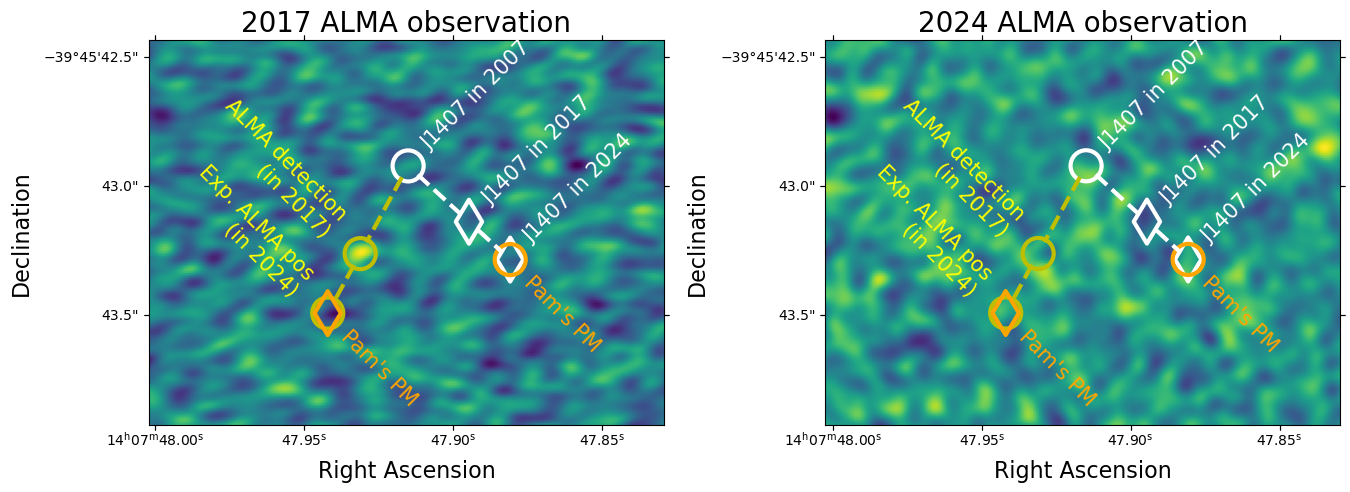

In [6]:
    
fig = plt.figure(figsize=(16, 5))

files = ['2017/uid___A001_X87c_X409._1SWASP_J140747.93-394542.6__sci.spw17_19_21_23.cont.I.pbcor.fits',
         '2024/J1407_cont.image.pbcor.fits']

for index,file in enumerate(files):
    """
    for each file, create a sub-plot
    """
    create_image(file,c_1ep_gaia_eclipse,2,index+1)